In [21]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from copy import deepcopy
import galsim
from astropy.coordinates import SkyCoord
from galsim import InterpolatedImage, Image
from galsim import roman

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs, psf
from mejiro.lenses import lens_util

In [2]:
num_lenses = 100
print(f'Collecting {num_lenses} lenses...')
pickled_lens_list = os.path.join(config.machine.dir_01, '01_hlwas_sim_detectable_lens_list.pkl')
lens_list = util.unpickle(pickled_lens_list)[:num_lenses]
print(f'Collected {len(lens_list)} lens(es).')

Collected 100 lens(es).


In [3]:
subhalo_params = {
    'r_tidal': 0.5,
    'sigma_sub': 0.055,
    'subhalo_cone': 5,
    'los_normalization': 0
}
imaging_params = {
    'bands': ['F106'],
    'oversample': 5,
    'num_pix': 45,
    'side': 4.95
}

r_tidal = subhalo_params['r_tidal']
sigma_sub = subhalo_params['sigma_sub']
subhalo_cone = subhalo_params['subhalo_cone']
los_normalization = subhalo_params['los_normalization']
bands = imaging_params['bands']
oversample = imaging_params['oversample']
num_pix = imaging_params['num_pix']
side = imaging_params['side']

In [4]:
# get sample lens
lens = lens_list[0]

In [5]:
lens._set_classes()

z_lens = round(lens.z_lens, 2)
z_source = round(lens.z_source, 2)
log_m_host = np.log10(lens.main_halo_mass)

cut_8_good = False
i = 0

while not cut_8_good:
    cut_8 = CDM(z_lens,
                z_source,
                sigma_sub=sigma_sub,
                log_mlow=8.,
                log_mhigh=10.,
                log_m_host=log_m_host,
                r_tidal=r_tidal,
                cone_opening_angle_arcsec=subhalo_cone,
                LOS_normalization=los_normalization)
    cut_8_good = lens_util.check_halo_image_alignment(lens, cut_8)
    i += 1
print(f'Generated cut_8 population after {i} iterations.')

med = CDM(z_lens,
        z_source,
        sigma_sub=sigma_sub,
        log_mlow=7.,
        log_mhigh=8.,
        log_m_host=log_m_host,
        r_tidal=r_tidal,
        cone_opening_angle_arcsec=subhalo_cone,
        LOS_normalization=los_normalization)

smol = CDM(z_lens,
        z_source,
        sigma_sub=sigma_sub,
        log_mlow=6.,
        log_mhigh=7.,
        log_m_host=log_m_host,
        r_tidal=r_tidal,
        cone_opening_angle_arcsec=subhalo_cone,
        LOS_normalization=los_normalization)

cut_7 = cut_8.join(med)
cut_6 = cut_7.join(smol)

# util.pickle(os.path.join(save_dir, f'realization_{lens.uid}_cut_8.pkl'), cut_8)
# util.pickle(os.path.join(save_dir, f'realization_{lens.uid}_cut_7.pkl'), cut_7)
# util.pickle(os.path.join(save_dir, f'realization_{lens.uid}_cut_6.pkl'), cut_6)

lens_cut_6 = deepcopy(lens)
lens_cut_7 = deepcopy(lens)
lens_cut_8 = deepcopy(lens)

lens_cut_6.add_subhalos(cut_6, suppress_output=True)
lens_cut_7.add_subhalos(cut_7, suppress_output=True)
lens_cut_8.add_subhalos(cut_8, suppress_output=True)

Generated cut_8 population after 26 iterations.


In [6]:
lenses = [lens_cut_6, lens_cut_7, lens_cut_8, lens]
titles = [f'cut_6_{lens.uid}', f'cut_7_{lens.uid}',
            f'cut_8_{lens.uid}', f'no_subhalos_{lens.uid}']
models = [i.get_array(num_pix=num_pix * oversample, side=side, band='F106') for i in lenses]

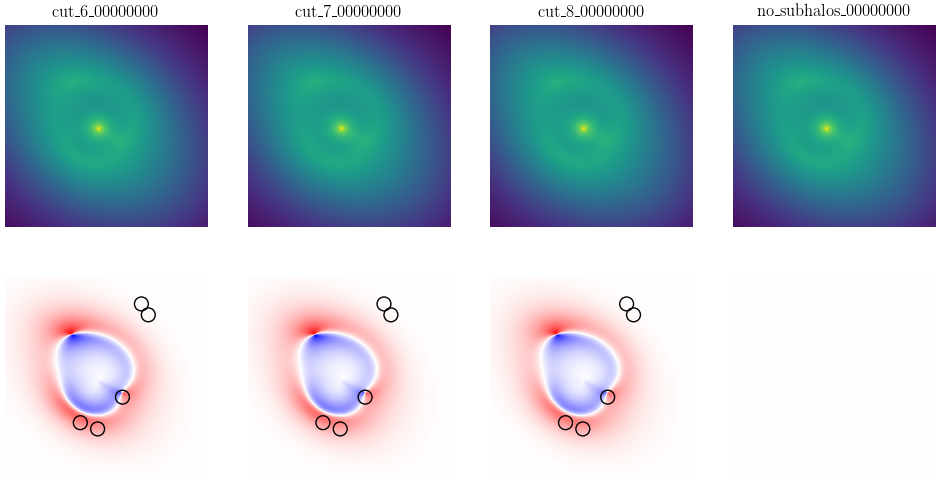

In [15]:
f, ax = plt.subplots(2, 4, figsize=(12, 6))
for i, model in enumerate(models):
    ax[0][i].imshow(np.log10(model))
    ax[0][i].set_title(titles[i])
    ax[0][i].axis('off')

res_array = [models[3] - models[i] for i in range(4)]
v = plot_util.get_v(res_array)
for i in range(4):
    axis = ax[1][i].imshow(models[3] - models[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

for i, lens in enumerate(lenses):
    realization = lens.realization
    if realization is not None:
        for halo in realization.halos:
            if halo.mass > 1e8:
                coords = lens_util.get_coords(45 * 5, delta_pix=0.11 / 5)
                ax[1][i].scatter(*coords.map_coord2pix(halo.x, halo.y), s=100, facecolors='none', edgecolors='black')
                # ax[1][i].plot(*coords.map_coord2pix(0, 0), 'o', color='black', markersize=5)

plt.show()

In [17]:
galsim_images = []
for sl, model, title in zip(lenses, models, titles):
    print(f'Processing model {title}...')
    gs_images, _ = gs.get_images(sl, [model], ['F106'], input_size=num_pix, output_size=num_pix,
                                grid_oversample=oversample, psf_oversample=oversample,
                                detector=1, detector_pos=(2048, 2048), suppress_output=False, validate=False, check_cache=True)
    galsim_images.append(gs_images[0])

Processing model cut_6_00000000...
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_5.pkl
Processing model cut_7_00000000...
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_5.pkl
Processing model cut_8_00000000...
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_5.pkl
Processing model no_subhalos_00000000...
Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_5.pkl


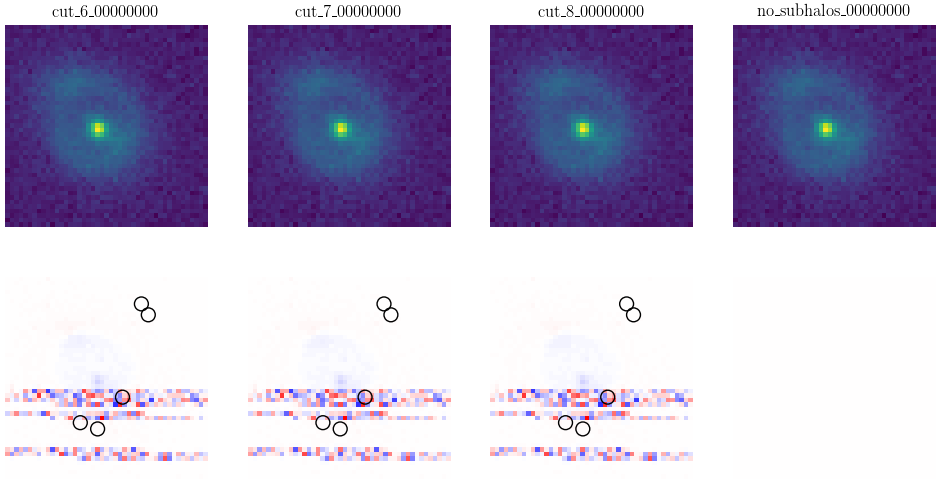

In [19]:
f, ax = plt.subplots(2, 4, figsize=(12, 6))
for i, image in enumerate(galsim_images):
    ax[0][i].imshow(np.log10(image))
    ax[0][i].set_title(titles[i])
    ax[0][i].axis('off')

res_array = [galsim_images[3] - galsim_images[i] for i in range(4)]
v = plot_util.get_v(res_array)
for i in range(4):
    axis = ax[1][i].imshow(galsim_images[3] - galsim_images[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

for i, lens in enumerate(lenses):
    realization = lens.realization
    if realization is not None:
        for halo in realization.halos:
            if halo.mass > 1e8:
                coords = lens_util.get_coords(45, delta_pix=0.11)
                ax[1][i].scatter(*coords.map_coord2pix(halo.x, halo.y), s=100, facecolors='none', edgecolors='black')

plt.show()

So it looks like the detector effects step (WebbPSF/Galsim) is the issue, and not the ray-shooting (lenstronomy).

In [29]:
model = models[0]
lens = lenses[0]
band = 'F106'

In [22]:
# create galsim rng
rng = galsim.UniformDeviate(seed=42)

In [41]:
# calculate sky backgrounds for each band
wcs_dict = gs.get_wcs(30, -30, date=None)
bkgs = gs.get_sky_bkgs(wcs_dict, bands, detector=1, exposure_time=146, num_pix=45)

In [42]:
# generate the PSFs I'll need for each unique band
psf_kernels = {}
for band in bands:
    psf_kernels[band] = psf.get_webbpsf_psf(band, detector=1, detector_position=(2048, 2048), oversample=5, check_cache=True, suppress_output=False)

Loading cached PSF: /home/btwedig/mejiro/mejiro/data/cached_psfs/F106_1_2048_2048_5.pkl


In [43]:
convolved = []

for model, lens in zip(models, lenses):
    # get interpolated image
    total_flux_cps = lens.get_total_flux_cps(band)
    interp = InterpolatedImage(Image(model, xmin=0, ymin=0), scale=0.11 / 5, flux=total_flux_cps * 146)

    # convolve image with PSF
    psf_kernel = psf_kernels[band]
    image = gs.convolve(interp, psf_kernel, 45)

    convolved.append(image)

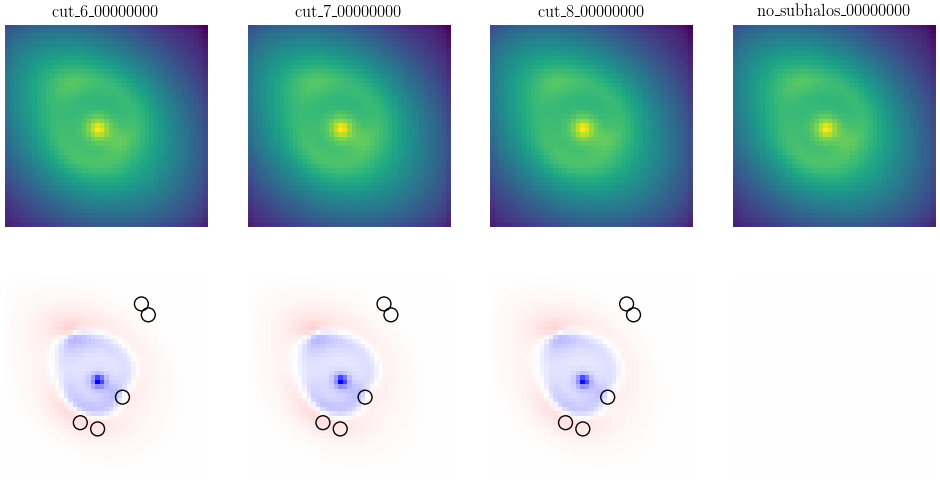

In [44]:
f, ax = plt.subplots(2, 4, figsize=(12, 6))
for i, image in enumerate(convolved):
    ax[0][i].imshow(np.log10(image.array))
    ax[0][i].set_title(titles[i])
    ax[0][i].axis('off')

res_array = [convolved[3].array - convolved[i].array for i in range(4)]
v = plot_util.get_v(res_array)
for i in range(4):
    axis = ax[1][i].imshow(convolved[3].array - convolved[i].array, cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

for i, lens in enumerate(lenses):
    realization = lens.realization
    if realization is not None:
        for halo in realization.halos:
            if halo.mass > 1e8:
                coords = lens_util.get_coords(45, delta_pix=0.11)
                ax[1][i].scatter(*coords.map_coord2pix(halo.x, halo.y), s=100, facecolors='none', edgecolors='black')

plt.show()

In [45]:
added_bkg = []
for image, lens in zip(convolved, lenses):
    image += bkgs[band]  # add sky background to convolved image
    image.quantize()  # integer number of photons are being detected, so quantize

    added_bkg.append(image)

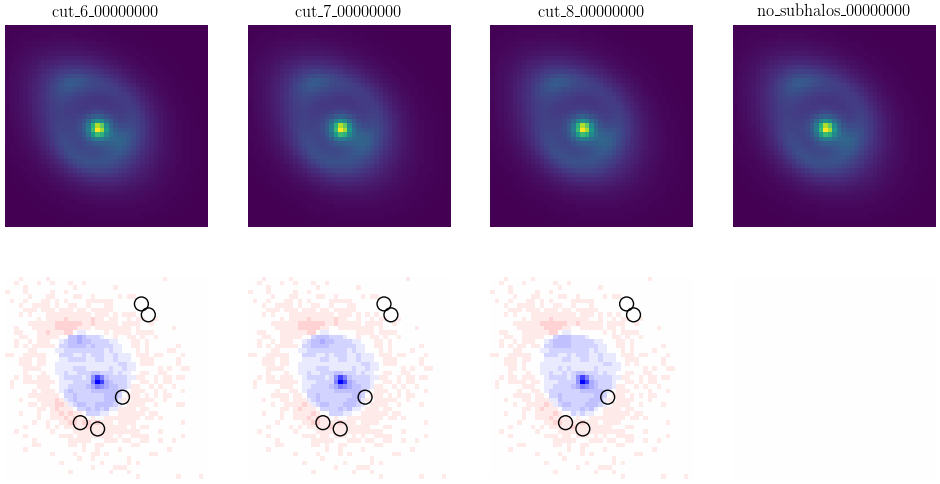

In [46]:
f, ax = plt.subplots(2, 4, figsize=(12, 6))
for i, image in enumerate(added_bkg):
    ax[0][i].imshow(np.log10(image.array))
    ax[0][i].set_title(titles[i])
    ax[0][i].axis('off')

res_array = [added_bkg[3].array - added_bkg[i].array for i in range(4)]
v = plot_util.get_v(res_array)
for i in range(4):
    axis = ax[1][i].imshow(added_bkg[3].array - added_bkg[i].array, cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

for i, lens in enumerate(lenses):
    realization = lens.realization
    if realization is not None:
        for halo in realization.halos:
            if halo.mass > 1e8:
                coords = lens_util.get_coords(45, delta_pix=0.11)
                ax[1][i].scatter(*coords.map_coord2pix(halo.x, halo.y), s=100, facecolors='none', edgecolors='black')

plt.show()

In [47]:
det_fx = []
for image, lens in zip(added_bkg, lenses):
    # add all detector effects
    galsim.roman.allDetectorEffects(image, prev_exposures=(), rng=rng, exptime=146)

    # get the array
    final_array = image.array

    # divide through by exposure time to get in units of counts/sec/pixel
    final_array /= 146

    det_fx.append(final_array)

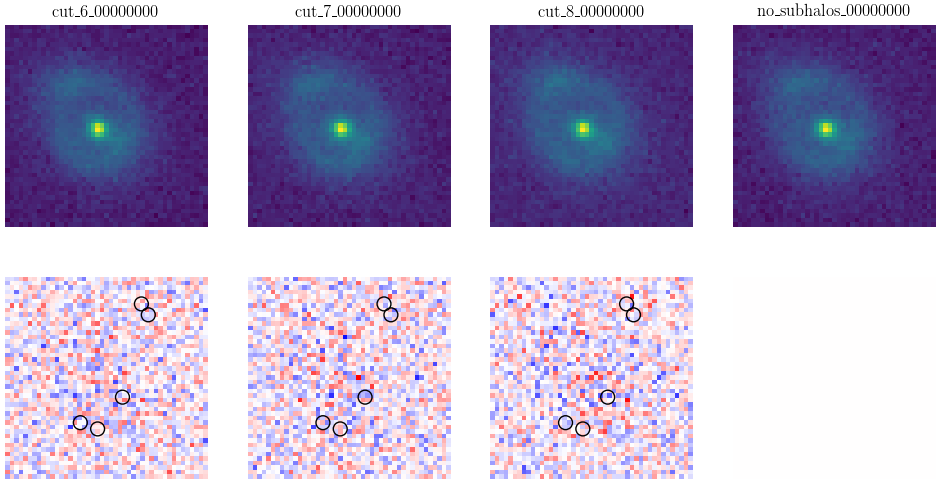

In [48]:
f, ax = plt.subplots(2, 4, figsize=(12, 6))
for i, image in enumerate(det_fx):
    ax[0][i].imshow(np.log10(image))
    ax[0][i].set_title(titles[i])
    ax[0][i].axis('off')

res_array = [det_fx[3] - det_fx[i] for i in range(4)]
v = plot_util.get_v(res_array)
for i in range(4):
    axis = ax[1][i].imshow(det_fx[3] - det_fx[i], cmap='bwr', vmin=-v, vmax=v)
    ax[1][i].set_axis_off()

for i, lens in enumerate(lenses):
    realization = lens.realization
    if realization is not None:
        for halo in realization.halos:
            if halo.mass > 1e8:
                coords = lens_util.get_coords(45, delta_pix=0.11)
                ax[1][i].scatter(*coords.map_coord2pix(halo.x, halo.y), s=100, facecolors='none', edgecolors='black')

plt.show()